In [78]:
import pandas as pd 

tables = ["ethereum.aave.ez_deposits", 
          "ethereum.aave.ez_liquidations", 
          "ethereum.aave.ez_repayments", 
          "ethereum.aave.ez_borrows", 
          "ethereum.aave.ez_withdraws"]

dfDeposits = pd.read_csv(tables[0].replace(".", "_") + ".csv")
dfliquidations = pd.read_csv(tables[1].replace(".", "_") + ".csv")
dfRepayments = pd.read_csv(tables[2].replace(".", "_") + ".csv")
dfBorrows = pd.read_csv(tables[3].replace(".", "_") + ".csv")
dfWithdrawals = pd.read_csv(tables[4].replace(".", "_") + ".csv")

# Need to clean up data that is pulled from DB 
dfDeposits['Time'] = dfDeposits['block_timestamp'].astype('datetime64[ns]')
dfliquidations['Time'] = dfliquidations['block_timestamp'].astype('datetime64[ns]')
dfRepayments['Time'] = dfRepayments['block_timestamp'].astype('datetime64[ns]')
dfBorrows['Time'] = dfBorrows['block_timestamp'].astype('datetime64[ns]')
dfWithdrawals['Time'] = dfWithdrawals['block_timestamp'].astype('datetime64[ns]')


/tmp/ipykernel_45410/3028945837.py:6: DtypeWarning: Columns (5,6,9,10,13,17,18,21,22,25,26,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  dfliquidations = pd.read_csv(tables[1].replace(".", "_") + ".csv")
/tmp/ipykernel_45410/3028945837.py:7: DtypeWarning: Columns (5,6,9,10,13,17,18,21,22,25,26,28,30,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dfRepayments = pd.read_csv(tables[2].replace(".", "_") + ".csv")
/tmp/ipykernel_45410/3028945837.py:8: DtypeWarning: Columns (5,6,9,10,13,17,18,21,22,25,26,28,30,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  dfBorrows = pd.read_csv(tables[3].replace(".", "_") + ".csv")


In [3]:
users = dfDeposits['depositor_address'].unique()
assets = dfDeposits['symbol'].unique()

In [108]:
# Lazy Way To Get Prices 

priceDict = {}

for asset in assets : 
    
    priceDict[asset] = dfDeposits[dfDeposits.symbol == asset].iloc[-1]['token_price']

In [109]:
priceDict

{'WETH': 1220.29,
 'DAI': 1.0,
 'AAVE': 54.935067465,
 'SNX': 1.719411251,
 'REN': 0.07937848579,
 'TUSD': 0.9958280502,
 'UNI': 5.34,
 'USDT': 1.009888705,
 'MKR': 509.877294402,
 'LINK': 6.029770294,
 'YFI': 6060.700113284,
 'WBTC': 16873.478982301,
 'ZRX': 0.1873294768,
 'USDC': 0.99917,
 'ENJ': 0.3171978727,
 'KNC': 3.316653621,
 'sUSD': 1.00448422,
 'MANA': 0.3892533784,
 'BUSD': 1.0,
 'BAT': 0.2250422779,
 'CRV': 0.5233086018,
 'GUSD': 0.9999671358,
 'BAL': 6.820383014,
 'xSUSHI': 1.807785883,
 'renFIL': 4.225854664,
 'RAI': 2.801944153,
 'AMPL': 1.058012829,
 'USDP': 0.9943281569,
 'DPI': 71.526085936,
 'FRAX': 0.9895462853,
 'FEI': 1.003098374,
 'stETH': 1201.324286831,
 'ENS': 13.969576099,
 'UST': 0.07764685095,
 'CVX': 4.150519566,
 '1INCH': 0.388556059,
 'LUSD': 1.022145257}

In [88]:
import random

# use smaller data set to mess around with data cleaning 
usersShort = random.choices(users, k=100)

In [89]:
df = pd.DataFrame({'user' : users})

In [ ]:
# Operations to clean Data


def find_first_deposit(row):
    return dfDeposits[dfDeposits.depositor_address == row['user']]['Time'].min()

def find_first_borrow(row):
    return dfBorrows[dfBorrows.borrower_address == row['user']]['Time'].min()

def find_last_withdraw(row):
    return dfWithdrawals[dfWithdrawals.depositor_address == row['user']]['Time'].max()

def find_last_liquidation(row):
    return dfliquidations[dfliquidations.borrower == row['user']]['Time'].max()

def find_total_deposits(row):
    return dfDeposits[(dfDeposits.depositor_address == row['user']) & (dfDeposits.symbol == asset)]['issued_tokens'].sum()

def find_total_withdrawals(row):
    return dfWithdrawals[(dfWithdrawals.depositor_address == row['user']) & (dfWithdrawals.symbol == asset)]['withdrawn_tokens'].sum()

def find_total_liquidations(row):
    return dfliquidations[(dfliquidations.borrower == row['user']) & (dfliquidations.collateral_token_symbol == asset)]['liquidated_amount'].sum()

def find_total_borrows(row):
    return dfBorrows[(dfBorrows.borrower_address == row['user']) & (dfBorrows.symbol == asset)]['borrowed_tokens'].sum()

def find_total_repayments(row):
    return dfBorrows[(dfRepayments.borrower == row['user']) & (dfBorrows.symbol == asset)]['repayed_tokens'].sum()


def total_deposits_usd(row):
    return dfDeposits[dfDeposits.depositor_address == row['user']]['supplied_usd'].sum()




In [205]:

"""
NOTE APPEARS TO BE SOME MINOR ISSUE WITH DATA ~~~ 

https://etherscan.io/tx/0x0a33776dcc36eaf3e57a3fa6ac7bdb1489565ab1bfb53cefae5bc45f3eba8f55

This shows as deposit but not withdrawal for that user -> need to take into account transfers of aTokens 

Also need to account for fact A Token is elastic i.e. grows in number as interest accrues... 

""" 

#### CLEAN UP THE FUCKING TRASH 

df['FirstDeposit'] = df.apply(find_first_deposit, axis=1)
df['FirstBorrow'] = df.apply(find_first_deposit, axis=1)
df['LastWithdraw'] = df.apply(find_last_withdraw, axis=1)
df['LastLiquidation'] = df.apply(find_last_liquidation, axis=1)
df['TotalUSDSupplied'] = df.apply(total_deposits_usd, axis=1)

#assetSimple = ['USDC']
colList = []

for asset in assets : 
    df['TotalDeposits' + asset] = df.apply(find_total_deposits, axis=1)
    df['TotalWithdrawals' + asset] = df.apply(find_total_withdrawals, axis=1)
    df['TotalLiquidations' + asset] = df.apply(find_total_liquidations, axis=1)
    df['TotalBorrows' + asset] = df.apply(find_total_borrows, axis=1)
    df['TotalRepayments' + asset] = df.apply(find_total_borrows, axis=1)
    df['Total Collateral' + asset] = df['TotalDeposits' + asset] - df['TotalWithdrawals' + asset] - df['TotalLiquidations' + asset]
    df['Total Collateral USD' + asset] = df['Total Collateral' + asset]*priceDict[asset]
    colList.append('Total Collateral USD' + asset)
    
df['Total Collateral USD'] = df[colList].sum(axis=1)

df['End Date'] = dfDeposits['Time'].max()


df['TotalDaysSinceEntry'] = (df['End Date'] - df['FirstDeposit']).dt.days
df['DaysUntilExit'] = (df['LastWithdraw'] - df['FirstDeposit']).dt.days


# number of deposits 
# number of withdrawals 
# number of borrows 

# total usd deposit value 
# total usd borrow value 
    

In [157]:

### assume they still have 2% of what was supplied + have withdrawn tough to perfectly calc this especially if user leaves dust 
df['Exit'] = (df['Total Collateral USD'] / df['TotalUSDSupplied'] < 0.05) & (df['LastWithdraw'] < dfDeposits['Time'].max())


In [194]:
# Filters - applied when calculating retention 
AssetDeposited = ['USDC']
minDepositValue = 10000


Days = range(500)
reducedDf = df[df['TotalUSDSupplied'] > minDepositValue]
retentionList = []

for day in Days :
    reducedDf = reducedDf[reducedDf['TotalDaysSinceEntry'] > day]
    n = len(reducedDf) 
    exits = (reducedDf[reducedDf.Exit == True])
    retention = 1 - sum(exits['DaysUntilExit'] < day) / len(reducedDf)
    retentionList.append(retention)

In [195]:
%matplotlib inline
import matplotlib.pyplot as plt


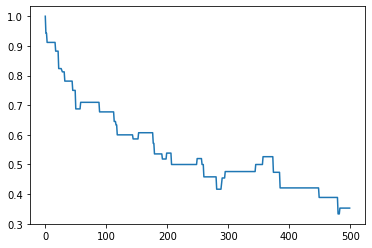

In [196]:
### Can Compare Retention rates with different filters i.e. see multiple lines
### potentially which users are leaving 

plt.plot(retentionList)

In [197]:
type(df['FirstDeposit'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [202]:
# Other Insights 
date = pd.Timestamp('2022-10-01')
# New Users 
minDepositValue = 100000

newUsers = df[(df['FirstDeposit'] > date) & (df['TotalUSDSupplied'] >= minDepositValue) & (df['Exit'] == False)]


In [203]:
### show them new users + give some insights i.e. what other apps they use & how they're using portfolio 
newUsers

,user,FirstDeposit,FirstBorrow,LastWithdraw,LastLiquidation,TotalDepositsUSDC,TotalWithdrawalsUSDC,TotalLiquidationsUSDC,TotalBorrowsUSDC,TotalRepaymentsUSDC,Total CollateralUSDC,TotalUSDSupplied,Total Collateral USDUSDC,Total Collateral USD,Retained,End Date,TotalDaysSinceEntry,DaysUntilExit,Exit
52,0xdd2ad0e989e1e9e6e2db52f59c1248cc3d966d0e,2022-12-03 09:27:23,2022-12-03 09:27:23,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,355033.860646,0.0,0.0,False,2022-12-31 23:59:11,28,NaN,False
96,0x21e3699d6612d786392dc9832498a3551d949c5c,2022-12-04 19:16:47,2022-12-04 19:16:47,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,505660.020856,0.0,0.0,False,2022-12-31 23:59:11,27,NaN,False


In [200]:
# Lost Whales
minDepositValue = 100000

lostUsers = df[(df['LastWithdraw'] > date) & (df['TotalUSDSupplied'] >= minDepositValue)]

In [201]:
lostUsers

,user,FirstDeposit,FirstBorrow,LastWithdraw,LastLiquidation,TotalDepositsUSDC,TotalWithdrawalsUSDC,TotalLiquidationsUSDC,TotalBorrowsUSDC,TotalRepaymentsUSDC,Total CollateralUSDC,TotalUSDSupplied,Total Collateral USDUSDC,Total Collateral USD,Retained,End Date,TotalDaysSinceEntry,DaysUntilExit,Exit
11,0xd069fa1e2d428f2580c553fa68c445640f281f79,2022-03-11 13:24:19,2022-03-11 13:24:19,2022-12-16 23:40:11,2022-06-15 08:07:51,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.625912e+06,0.000000,0.000000,False,2022-12-31 23:59:11,295,280.0,True
34,0x2d220b022e0b1c16a114f800662993e16019d8b4,2022-06-15 03:23:00,2022-06-15 03:23:00,2022-12-09 03:21:59,NaT,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.320277e+05,0.000000,0.000000,False,2022-12-31 23:59:11,199,176.0,True
37,0xbbced90faac4490bf5e958aa45b06c43d2aa1048,2022-11-03 13:01:47,2022-11-03 13:01:47,2022-11-25 08:33:59,NaT,99973.330433,100035.654851,0.0,0.0,0.0,-62.324418,2.283736e+05,-62.272689,-62.272689,False,2022-12-31 23:59:11,58,21.0,True


In [ ]:
### IDEA WOULD BE THEY CAN DRAW FURTHER INSIGHTS FROM THESE USERS 